# Analiza 'glipses' u govornom materijalu
Load:
 - Čisti stimulus (VCV)
 - Maska (SSN)
 - Stimulus plus maska (3 različita SNR)

# [1] Generating a structured nested dictionary

In [1]:
# Define the structure of the nested dictionary
data = {
    'SNR_-2': {
        'govornik_1': {},
        'govornik_2': {},
        'govornik_3': {},
        'govornik_4': {}
    },
    'SNR_+0': {
        'govornik_1': {},
        'govornik_2': {},
        'govornik_3': {},
        'govornik_4': {}
    },
    'SNR_+2': {
        'govornik_1': {},
        'govornik_2': {},
        'govornik_3': {},
        'govornik_4': {}
    }
}

# Define the stimuli
stimuli = ['apa',
           'ata',
           'aka',
           'aba',
           'ada',
           'aga',
           'asa',
           'aša',
           'aza',
           'aža',
           'afa',
           'aha',
           'aca',
           'ača',
           'ađa',
           'aja',
           'ana',
           'ama',
           'ara',
           'ala',
           'ava']

# Initialize the nested dictionary with empty lists for each stimulus
for snr in data:
    for speaker in data[snr]:
        for stimulus in stimuli:
            data[snr][speaker][stimulus] = []

print(f"len(data): {len(data)}")
print(f"data.keys(): {data.keys()}")
print(f"len(data.keys()): {len(data.keys())}")

len(data): 3
data.keys(): dict_keys(['SNR_-2', 'SNR_+0', 'SNR_+2'])
len(data.keys()): 3


In [2]:
# Print the number of noise conditions
print(f"Number of noise conditions: {len(data)}")
print(f"Noise conditions: {list(data.keys())}")

# Iterate over each noise condition to print the number of speakers and stimuli
for snr_condition, speakers in data.items():
    print(f"\nNoise condition: {snr_condition}")
    
    # Number of speakers in the current noise condition
    num_speakers = len(speakers)
    print(f"  Number of speakers: {num_speakers}")
    print(f"  Speakers: {list(speakers.keys())}")
    
    # Iterate over each speaker to print the number of stimuli
    for speaker, stimuli in speakers.items():
        num_stimuli = len(stimuli)
        print(f"    Speaker: {speaker}")
        print(f"      Number of stimuli: {num_stimuli}")
        print(f"      Stimuli: {list(stimuli.keys())}")


Number of noise conditions: 3
Noise conditions: ['SNR_-2', 'SNR_+0', 'SNR_+2']

Noise condition: SNR_-2
  Number of speakers: 4
  Speakers: ['govornik_1', 'govornik_2', 'govornik_3', 'govornik_4']
    Speaker: govornik_1
      Number of stimuli: 21
      Stimuli: ['apa', 'ata', 'aka', 'aba', 'ada', 'aga', 'asa', 'aša', 'aza', 'aža', 'afa', 'aha', 'aca', 'ača', 'ađa', 'aja', 'ana', 'ama', 'ara', 'ala', 'ava']
    Speaker: govornik_2
      Number of stimuli: 21
      Stimuli: ['apa', 'ata', 'aka', 'aba', 'ada', 'aga', 'asa', 'aša', 'aza', 'aža', 'afa', 'aha', 'aca', 'ača', 'ađa', 'aja', 'ana', 'ama', 'ara', 'ala', 'ava']
    Speaker: govornik_3
      Number of stimuli: 21
      Stimuli: ['apa', 'ata', 'aka', 'aba', 'ada', 'aga', 'asa', 'aša', 'aza', 'aža', 'afa', 'aha', 'aca', 'ača', 'ađa', 'aja', 'ana', 'ama', 'ara', 'ala', 'ava']
    Speaker: govornik_4
      Number of stimuli: 21
      Stimuli: ['apa', 'ata', 'aka', 'aba', 'ada', 'aga', 'asa', 'aša', 'aza', 'aža', 'afa', 'aha', 'aca',

In [ ]:
def explore_dict(d, level=0):
    indent = "  " * level
    if isinstance(d, dict):
        for key, value in d.items():
            print(f"{indent}Key: {key} (Type: {type(value).__name__})")
            explore_dict(value, level + 1)
    elif isinstance(d, list):
        if len(d) > 0:
            print(f"{indent}List of {len(d)} items (Type: {type(d[0]).__name__})")
        else:
            print(f"{indent}Empty list")
    else:
        print(f"{indent}Value: {d} (Type: {type(d).__name__})")

# Example usage
explore_dict(data)


## Skip to [7] for MFCC

# [2] Main audio file STFT analysis and dict populating

Takes about 34s to finish

In [3]:
%%time

import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.io import wavfile
from scipy.signal import stft

# Define parameters
speakers = ['govornik_1', 'govornik_2', 'govornik_3', 'govornik_4']
snr_conditions = ['SNR_-2', 'SNR_+0', 'SNR_+2']

# Map speaker to SSN_gX part
speaker_mapping = {
    'govornik_1': 'g1',
    'govornik_2': 'g2',
    'govornik_3': 'g3',
    'govornik_4': 'g4'
}

# Map SNR condition to the corresponding number
snr_mapping = {
    'SNR_-2': '70',
    'SNR_+0': '68',
    'SNR_+2': '66'
}

# SNR filename prefix mapping
snr_prefix_mapping = {
    'SNR_-2': 'S1',
    'SNR_+0': 'S2',
    'SNR_+2': 'S3'
}

# Base paths
base_path = r'C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\Diplomski Rad\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\SSN all all'
base_speech_mask_path = r'C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\Diplomski Rad\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV'

# Initialize the data dictionary
data = {snr: {speaker: {} for speaker in speakers} for snr in snr_conditions}

def process_and_store_data(speaker, snr_condition, stimulus, speech_mask_file_path, mask, sr, snr_prefix):
    # Load the speech + mask audio file
    _, speech_mask = wavfile.read(speech_mask_file_path)

    # Determine the minimum length of the audio files
    min_length = min(len(mask), len(speech_mask))

    # Trim the audio files to the minimum length
    mask = mask[:min_length]
    speech_mask = speech_mask[:min_length]

    # Compute STFT
    f, t, mask_stft = stft(mask, sr)
    _, _, speech_mask_stft = stft(speech_mask, sr)

    # Convert to power spectrograms (magnitude squared)
    mask_power = np.abs(mask_stft)**2 # Adding a slightly larger value to avoid division by zero
    speech_mask_power = np.abs(speech_mask_stft)**2

    # Calculate SNR
    snr = 10 * np.log10(speech_mask_power / (mask_power + 1e-3))  # Adding a slightly larger value to avoid division by zero

    # Normalize SNR values to the range [0, 1]
    snr_normalized = (snr - np.min(snr)) / (np.max(snr) - np.min(snr))

    # Set values where SNR <= 3 to 0
    glimpses = np.where(snr > 3, snr_normalized, 0)
    
    # Trim the glimpses array if its length is longer than the shortest length
    shortest_length = min(len(glimpses[1]), len(mask))  # Calculate the shortest length among glimpses and mask
    if len(glimpses[1]) > shortest_length:  # Check the length along the second axis
        trim_length = len(glimpses[1]) - shortest_length
        trim_start = trim_length // 2
        trim_end = len(glimpses[1]) - (trim_length - trim_start)
        glimpses = glimpses[:, trim_start:trim_end]  # Trim along the second axis

    # Store the data in the dictionary
    data[snr_condition][speaker][stimulus] = {
        'original': speech_mask,
        'mask': mask,
        'glimpses': glimpses,
        'time': t,
        'frequency': f
    }

    # Visualize the glimpses on the spectrogram
    plt.figure(figsize=(10, 3))
    plt.pcolormesh(t, f, glimpses, shading='nearest', cmap='gray_r', vmin=0, vmax=1)
    
    title = f'{snr_prefix}{stimulus}'
    plt.title(title + ' - Glimpses (SNR > 3 dB)')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.tight_layout()
    
    # Save the plot as a .png file in the same directory, including the SNR prefix
    output_filename = os.path.join(os.path.dirname(speech_mask_file_path), f'{title}.png'.replace(' ', '_'))
    plt.savefig(output_filename, format='png', bbox_inches='tight')
    plt.close()  # Close the plot to free memory




# Iterate over all speakers and SNR conditions
for speaker in speakers:
    for snr_condition in snr_conditions:
        ssn_part = speaker_mapping[speaker]
        snr_number = snr_mapping[snr_condition]

        # Construct the mask_dir path using string formatting
        mask_dir = f'{base_path}\SSN_{ssn_part}_{snr_number}.wav'
        
        # Construct the speech_mask_dir path using string formatting
        speech_mask_folder_mapping = {
            'govornik_1': 'wav g1 VCV mask',
            'govornik_2': 'wav g2 VCV mask',
            'govornik_3': 'wav g3 VCV mask',
            'govornik_4': 'wav g4 VCV mask'
        }
        speech_mask_folder = speech_mask_folder_mapping[speaker]
        speech_mask_dir = os.path.join(base_speech_mask_path, speech_mask_folder)

        print(f"Processing speaker: {speaker}, SNR condition: {snr_condition}\n")
        #print(f"mask_dir: {mask_dir}")
        #print(f"speech_mask_dir: {speech_mask_dir}")

        # Load the mask file
        sr, mask = wavfile.read(mask_dir)

        # Get the correct SNR prefix for the current SNR condition
        snr_prefix = snr_prefix_mapping[snr_condition]

        # List all files in the speaker's directory
        speech_mask_filenames = [f for f in os.listdir(speech_mask_dir) if f.endswith('.wav') and f.startswith(snr_prefix)]

        print(f"speech_mask_filenames: {speech_mask_filenames[:2]} ... (total {len(speech_mask_filenames)})\n")

        # Process each file
        for speech_mask_filename in speech_mask_filenames:
            speech_mask_file_path = os.path.join(speech_mask_dir, speech_mask_filename)
            stimulus = os.path.splitext(speech_mask_filename)[0][2:]  # Extract the stimulus part of the filename
            process_and_store_data(speaker, snr_condition, stimulus, speech_mask_file_path, mask, sr, snr_prefix)

# Check data dictionary content
print(f"\nlen(data): {len(data)}")
print(f"data.keys(): {data.keys()}\n")


Processing speaker: govornik_1, SNR condition: SNR_-2

speech_mask_filenames: ['S1aba.wav', 'S1aca.wav'] ... (total 21)

Processing speaker: govornik_1, SNR condition: SNR_+0

speech_mask_filenames: ['S2aba.wav', 'S2aca.wav'] ... (total 21)

Processing speaker: govornik_1, SNR condition: SNR_+2

speech_mask_filenames: ['S3aba.wav', 'S3aca.wav'] ... (total 21)

Processing speaker: govornik_2, SNR condition: SNR_-2

speech_mask_filenames: ['S1aba.wav', 'S1aca.wav'] ... (total 21)

Processing speaker: govornik_2, SNR condition: SNR_+0

speech_mask_filenames: ['S2aba.wav', 'S2aca.wav'] ... (total 21)

Processing speaker: govornik_2, SNR condition: SNR_+2

speech_mask_filenames: ['S3aba.wav', 'S3aca.wav'] ... (total 21)

Processing speaker: govornik_3, SNR condition: SNR_-2

speech_mask_filenames: ['S1aba.wav', 'S1aca.wav'] ... (total 21)



<timed exec>:61: RuntimeWarning: divide by zero encountered in log10
<timed exec>:64: RuntimeWarning: invalid value encountered in subtract
<timed exec>:64: RuntimeWarning: invalid value encountered in divide


Processing speaker: govornik_3, SNR condition: SNR_+0

speech_mask_filenames: ['S2aba.wav', 'S2aca.wav'] ... (total 21)

Processing speaker: govornik_3, SNR condition: SNR_+2

speech_mask_filenames: ['S3aba.wav', 'S3aca.wav'] ... (total 21)

Processing speaker: govornik_4, SNR condition: SNR_-2

speech_mask_filenames: ['S1aba.wav', 'S1aca.wav'] ... (total 21)

Processing speaker: govornik_4, SNR condition: SNR_+0

speech_mask_filenames: ['S2aba.wav', 'S2aca.wav'] ... (total 21)

Processing speaker: govornik_4, SNR condition: SNR_+2

speech_mask_filenames: ['S3aba.wav', 'S3aca.wav'] ... (total 21)


len(data): 3
data.keys(): dict_keys(['SNR_-2', 'SNR_+0', 'SNR_+2'])

CPU times: total: 32.6 s
Wall time: 34 s


## CHECK if dictionary had filled properly

In [4]:
# Function to print sample data points
def print_sample_data(data, num_samples=3):
    for snr_condition, snr_data in data.items():
        print(f"SNR Condition: {snr_condition}")
        for speaker, speaker_data in snr_data.items():
            print(f"\tSpeaker: {speaker}")
            for stimulus, stimulus_data in speaker_data.items():
                print(f"\t\tStimulus: {stimulus}")
                print(f"\t\t\tOriginal Shape: {stimulus_data['original'].shape}")
                print(f"\t\t\tMask Shape: {stimulus_data['mask'].shape}")
                print(f"\t\t\tGlimpses Shape: {stimulus_data['glimpses'].shape}")
                print(f"\t\t\tGlimpses Example:")
                print(stimulus_data['glimpses'][:8, :5])  # Print a small portion of the glimpses
                print(f"\t\t\tTime: {stimulus_data['time'].shape}")  # Print the shape of time array
                print(f"\t\t\tFrequency: {stimulus_data['frequency'].shape}")  # Print the shape of frequency array
                num_samples -= 1
                if num_samples <= 0:
                    return

# Call the function to print sample data points
print_sample_data(data)


SNR Condition: SNR_-2
	Speaker: govornik_1
		Stimulus: aba
			Original Shape: (15930,)
			Mask Shape: (15930,)
			Glimpses Shape: (129, 126)
			Glimpses Example:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.64111644]
 [0.         0.         0.74585676 0.         0.6782577 ]
 [0.         0.         0.         0.         0.59203255]]
			Time: (126,)
			Frequency: (129,)
		Stimulus: aca
			Original Shape: (18960,)
			Mask Shape: (18960,)
			Glimpses Shape: (129, 150)
			Glimpses Example:
[[0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.      

# [3] Save Dictionary (34MB)

In [53]:
import pickle

# Define the file path to save the dictionary
output_file_path = r"C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\GM_data_dict-v2.0.pkl"

# Save the dictionary using pickle
with open(output_file_path, "wb") as file:
    pickle.dump(data, file)

print(f"Dictionary saved to {output_file_path}")


Dictionary saved to C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\GM_data_dict-v2.0.pkl


# [4] Load Dictionary

In [1]:
import pickle

# Load the dictionary from the file
output_file_path = r"C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\GM_data_dict-v2.0.pkl"

with open(output_file_path, "rb") as file:
    data = pickle.load(file)

print("Dictionary loaded successfully!")


Dictionary loaded successfully!


# [5] Analysis: Average out by speakers, per SNR condition

In [20]:
save5_png_path = r"C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\PNG analiza"

In [52]:
import numpy as np

# Define selected speakers and noise conditions
selected_speakers = ['govornik_1', 'govornik_2','govornik_3', 'govornik_4']
selected_noise_condition = 'SNR_+2'

# Function to find the longest time length
def find_longest_time_length(data, selected_speakers, selected_noise_condition):
    longest_length = 0
    for stimulus in data[selected_noise_condition][selected_speakers[0]]:
        for speaker in selected_speakers:
            glimpses_length = data[selected_noise_condition][speaker][stimulus]['glimpses'].shape[1]  # Get the length along the time axis
            if glimpses_length > longest_length:
                longest_length = glimpses_length
    return longest_length

# Function to pad glimpses to the longest time length equally on both sides
def pad_glimpses(glimpses, longest_length):
    total_padding = longest_length - glimpses.shape[1]
    left_padding = total_padding // 2
    right_padding = total_padding - left_padding
    pad_width = ((0, 0), (left_padding, right_padding))
    return np.pad(glimpses, pad_width, mode='constant', constant_values=0)

# Function to calculate the average glimpses for each stimulus
def calculate_average_glimpses(data, selected_speakers, selected_noise_condition):
    average_glimpses = {}
    longest_length = find_longest_time_length(data, selected_speakers, selected_noise_condition)
    
    # Pad the glimpses and calculate the average glimpses for each stimulus
    for stimulus in data[selected_noise_condition][selected_speakers[0]]:
        glimpses_sum = None
        
        # Iterate over each speaker for the current stimulus
        for speaker in selected_speakers:
            glimpses = data[selected_noise_condition][speaker][stimulus]['glimpses']
            padded_glimpses = pad_glimpses(glimpses, longest_length)
            
            # Initialize glimpses_sum if it's None
            if glimpses_sum is None:
                glimpses_sum = padded_glimpses
            else:
                # Add the padded glimpses to the existing sum
                glimpses_sum += padded_glimpses
        
        # Calculate the average glimpses for the current stimulus
        average_glimpses[stimulus] = glimpses_sum / len(selected_speakers)
    
    return average_glimpses

# Calculate the average glimpses
average_glimpses = calculate_average_glimpses(data, selected_speakers, selected_noise_condition)

# Visualize and save the averaged glimpses
for stimulus, glimpses in average_glimpses.items():
    print(f"Plotting: {selected_noise_condition} - {stimulus}")
    print("Glimpses shape before plotting:", glimpses.shape)

    plt.figure(figsize=(8, 6))
    plt.pcolormesh(range(glimpses.shape[1]), range(glimpses.shape[0]), glimpses, shading='nearest', cmap='gray_r', vmin=0, vmax=1)
    
    plt.title(f'{selected_noise_condition} - {stimulus} - Average Glimpses')
    plt.ylabel('Frequency [bins]')
    plt.xlabel('Time [bins]')
    plt.tight_layout()
    
    # Save the plot as a .png file in the current directory
    speaker_suffix = '+'.join([speaker_mapping[speaker] for speaker in selected_speakers])
    snr_prefix = snr_prefix_mapping[selected_noise_condition]
    output_filename = f'{stimulus}_avg_glimpses_{snr_prefix}-{speaker_suffix}.png'.replace(' ', '_')
    plt.savefig(os.path.join(save5_png_path, output_filename), format='png', bbox_inches='tight')
    plt.close()


Plotting: SNR_+2 - aba
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - aca
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - ada
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - afa
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - aga
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - aha
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - aja
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - aka
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - ala
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - ama
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - ana
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - apa
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - ara
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - asa
Glimpses shape before plotting: (129, 161)
Plotting: SNR_+2 - ata
Glimpses shape before plotting: (129, 161)
Plotting: 

## visual debugger - before and after, saves them

# [6] PyTorch testing

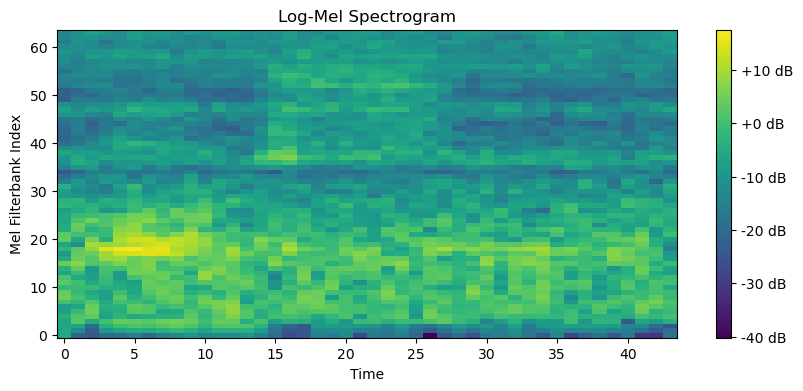

In [3]:
import torchaudio
import torch
import matplotlib.pyplot as plt

torch_test = r"C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\wav g4 VCV mask\S1aša.wav"

# Load the audio file
waveform, sample_rate = torchaudio.load(torch_test)


# Resample to a common sample rate (optional)
waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

# Convert to mono if stereo
if waveform.shape[0] > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

# Compute the log-mel spectrogram
mel_specgram = torchaudio.transforms.MelSpectrogram(
    sample_rate=16000, n_fft=400, win_length=400, hop_length=160, n_mels=64
)(waveform)

# Convert to decibels
log_mel_specgram = torchaudio.transforms.AmplitudeToDB()(mel_specgram)

# Plot the log-mel spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(log_mel_specgram[0].numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Filterbank Index')
plt.colorbar(format='%+2.0f dB')
plt.show()


Plotting: SNR_-2 - aba
Glimpses shape before plotting: (129, 107)


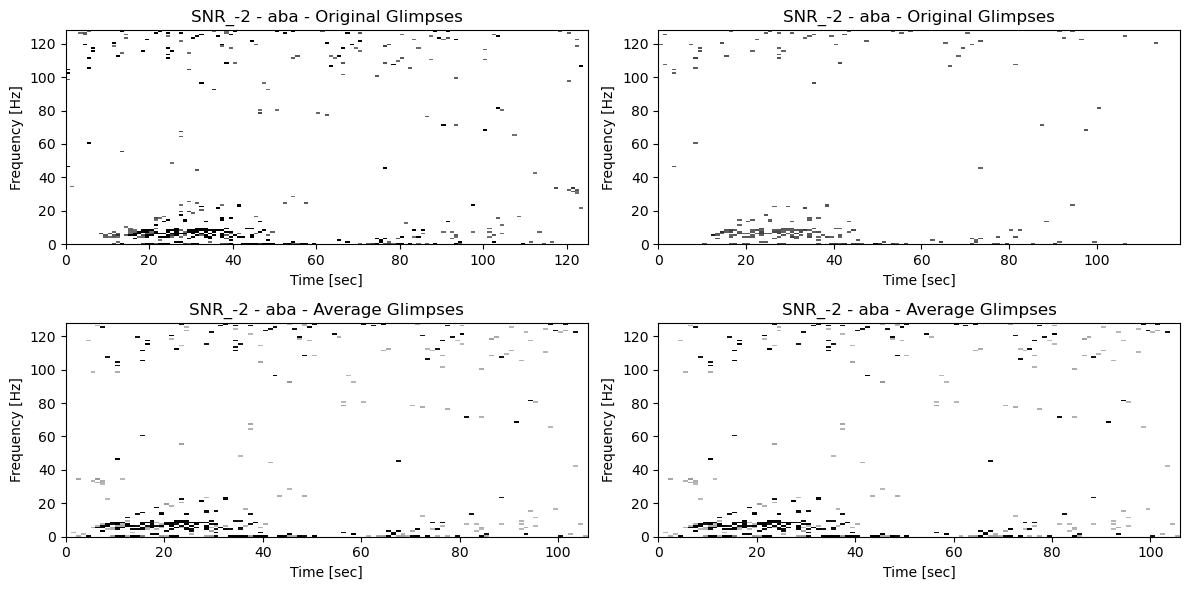

Plotting: SNR_-2 - aca
Glimpses shape before plotting: (129, 107)


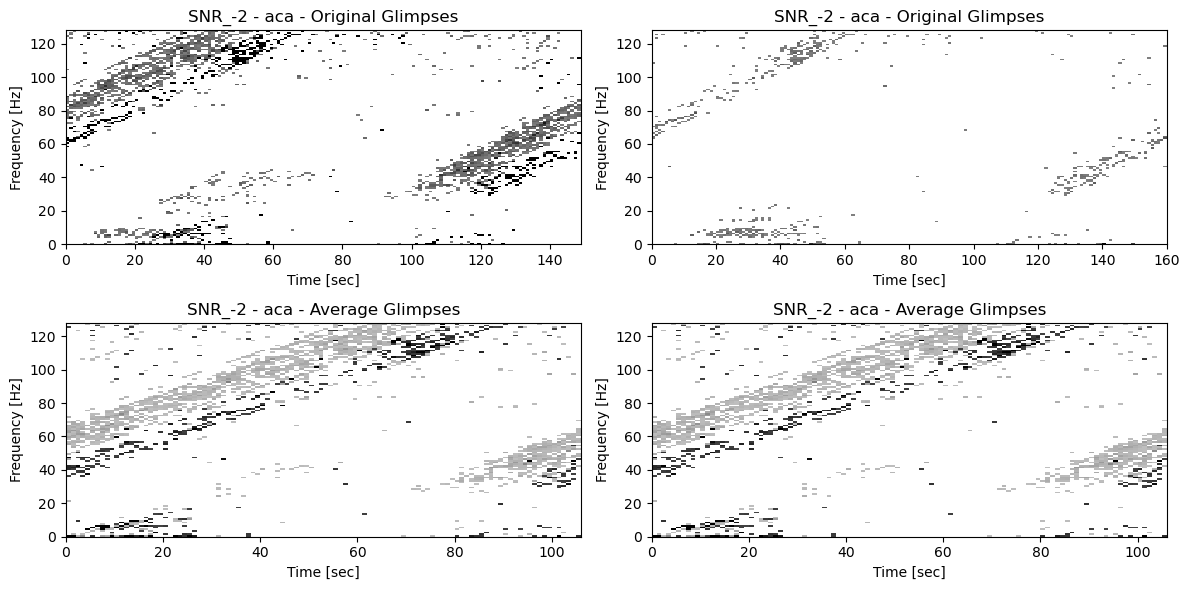

In [13]:
# Calculate the average glimpses
average_glimpses = calculate_average_glimpses(data, selected_speakers, selected_noise_condition)

# Visualize the averaged glimpses
for i, (stimulus, glimpses) in enumerate(average_glimpses.items()):
    if i >= 2:  # Only visualize the first two stimuli
        break
    
    print(f"Plotting: {selected_noise_condition} - {stimulus}")
    print("Glimpses shape before plotting:", glimpses.shape)
    
    # Define a reversed grayscale colormap
    reversed_gray_cmap = plt.cm.gray.reversed()
    
    plt.figure(figsize=(12, 6))
    
    # Plot original glimpses
    plt.subplot(2, 2, 1)
    plt.pcolormesh(data[selected_noise_condition][selected_speakers[0]][stimulus]['glimpses'], shading='nearest', cmap=reversed_gray_cmap, vmin=0, vmax=1)
    plt.title(f'{selected_noise_condition} - {stimulus} - Original Glimpses')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    
    plt.subplot(2, 2, 2)
    plt.pcolormesh(data[selected_noise_condition][selected_speakers[1]][stimulus]['glimpses'], shading='nearest', cmap=reversed_gray_cmap, vmin=0, vmax=1)
    plt.title(f'{selected_noise_condition} - {stimulus} - Original Glimpses')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    
    # Plot averaged glimpses
    plt.subplot(2, 2, 3)
    plt.pcolormesh(glimpses, shading='nearest', cmap=reversed_gray_cmap, vmin=0, vmax=1)
    plt.title(f'{selected_noise_condition} - {stimulus} - Average Glimpses')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    
    plt.subplot(2, 2, 4)
    plt.pcolormesh(glimpses, shading='nearest', cmap=reversed_gray_cmap, vmin=0, vmax=1)
    plt.title(f'{selected_noise_condition} - {stimulus} - Average Glimpses')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    
    plt.tight_layout()
    
    # Display the plots
    plt.show()


NameError: name 'reversed_gray_cmap' is not defined

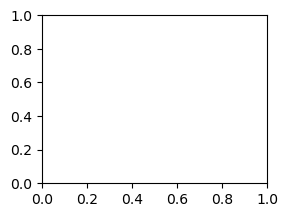

In [8]:
# Plot original glimpses
plt.subplot(2, 2, 1)
plt.imshow(data[selected_noise_condition][selected_speakers[0]][stimulus]['glimpses'], aspect='auto', cmap=reversed_gray_cmap, origin='lower', extent=[0, 1, 0, 1])
plt.title(f'{selected_noise_condition} - {stimulus} - Original Glimpses')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(2, 2, 2)
plt.imshow(data[selected_noise_condition][selected_speakers[1]][stimulus]['glimpses'], aspect='auto', cmap=reversed_gray_cmap, origin='lower', extent=[0, 1, 0, 1])
plt.title(f'{selected_noise_condition} - {stimulus} - Original Glimpses')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')


In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Define selected speakers and noise conditions
selected_speakers = ['govornik_1', 'govornik_3']
selected_noise_condition = 'SNR_-2'

# Function to calculate the average glimpses for each stimulus
def calculate_average_glimpses(data, selected_speakers, selected_noise_condition):
    average_glimpses = {}
    shortest_length = None
    
    # Find the shortest length
    for stimulus in data[selected_noise_condition][selected_speakers[0]]:
        glimpses_lengths = [len(data[selected_noise_condition][speaker][stimulus]['glimpses'][1]) for speaker in selected_speakers]  # Get the length along the second axis
        shortest_length = min(glimpses_lengths) if shortest_length is None else min(shortest_length, *glimpses_lengths)
    
    #print("Shortest length:", shortest_length)  # Add print statement to check the shortest length
    
    # Calculate the average glimpses for each stimulus
    for stimulus in data[selected_noise_condition][selected_speakers[0]]:
        glimpses_sum = None
        
        # Iterate over each speaker for the current stimulus
        for speaker in selected_speakers:
            glimpses = data[selected_noise_condition][speaker][stimulus]['glimpses']
            
            # Trim the glimpses array if its length is longer than the shortest length
            if len(glimpses[1]) > shortest_length:  # Check the length along the second axis
                trim_length = len(glimpses[1]) - shortest_length
                trim_start = trim_length // 2
                trim_end = len(glimpses[1]) - (trim_length - trim_start)
                glimpses = glimpses[:, trim_start:trim_end]  # Trim along the second axis
                
            # Initialize glimpses_sum if it's None
            if glimpses_sum is None:
                glimpses_sum = glimpses
            else:
                # Add the glimpses to the existing sum
                glimpses_sum += glimpses
        
        # Calculate the average glimpses for the current stimulus
        average_glimpses[stimulus] = glimpses_sum / len(selected_speakers)
    
    return average_glimpses

# Calculate the average glimpses
average_glimpses = calculate_average_glimpses(data, selected_speakers, selected_noise_condition)

# Visualize and save the averaged glimpses
for stimulus, glimpses in average_glimpses.items():
    
    print(f"Plotting: {selected_noise_condition} - {stimulus}")
    
    # Define a reversed grayscale colormap
    reversed_gray_cmap = plt.cm.gray.reversed()
    
    plt.figure(figsize=(10, 3))
    plt.pcolormesh(glimpses, shading='nearest', cmap=reversed_gray_cmap, vmin=0, vmax=1)
    
    plt.title(f'{selected_noise_condition} - {stimulus} - Average Glimpses')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.tight_layout()
    
    # Save the plot as a .png file in the current directory
    output_filename = f'{stimulus}_average_glimpses.png'.replace(' ', '_')
    plt.savefig(os.path.join(save5_png_path, output_filename), format='png', bbox_inches='tight')
    plt.close()


Plotting: SNR_-2 - aba
Plotting: SNR_-2 - aca
Plotting: SNR_-2 - ada
Plotting: SNR_-2 - afa
Plotting: SNR_-2 - aga
Plotting: SNR_-2 - aha
Plotting: SNR_-2 - aja
Plotting: SNR_-2 - aka
Plotting: SNR_-2 - ala
Plotting: SNR_-2 - ama
Plotting: SNR_-2 - ana
Plotting: SNR_-2 - apa
Plotting: SNR_-2 - ara
Plotting: SNR_-2 - asa
Plotting: SNR_-2 - ata
Plotting: SNR_-2 - ava
Plotting: SNR_-2 - aza
Plotting: SNR_-2 - ača
Plotting: SNR_-2 - ađa
Plotting: SNR_-2 - aša
Plotting: SNR_-2 - aža


# [7] USING PYTORCH TORCHAUDIO MEL LOG SPECTROGRAMS

Takes 48s to finish.

In [3]:
%%time

import torch
import torchaudio
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.io import wavfile
#from scipy.signal import stft

# Define parameters
speakers = ['govornik_1', 'govornik_2', 'govornik_3', 'govornik_4']
snr_conditions = ['SNR_-2', 'SNR_+0', 'SNR_+2']

# Map speaker to SSN_gX part
speaker_mapping = {
    'govornik_1': 'g1',
    'govornik_2': 'g2',
    'govornik_3': 'g3',
    'govornik_4': 'g4'
}

# Map SNR condition to the corresponding number
snr_mapping = {
    'SNR_-2': '70',
    'SNR_+0': '68',
    'SNR_+2': '66'
}

# SNR filename prefix mapping
snr_prefix_mapping = {
    'SNR_-2': 'S1',
    'SNR_+0': 'S2',
    'SNR_+2': 'S3'
}

# Base paths
base_path = r'C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\Diplomski Rad\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\SSN all all'
base_speech_mask_path = r'C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\Diplomski Rad\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV'

# Initialize the data dictionary
data = {snr: {speaker: {} for speaker in speakers} for snr in snr_conditions}

def process_and_store_data(speaker, snr_condition, stimulus, speech_mask_file_path, mask, sr, snr_prefix):
    # Load the speech + mask audio file
    speech_mask, sr = torchaudio.load(speech_mask_file_path)

    # Determine the minimum length of the audio files
    min_length_audio = min(mask.size(1), speech_mask.size(1))

    # Trim the audio files to the minimum length
    mask = mask[:, :min_length_audio]
    speech_mask = speech_mask[:, :min_length_audio]

    # Convert to log-mel spectrograms
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=sr, n_fft=400, win_length=400, hop_length=160, n_mels=64)
    mask_mel = mel_transform(mask)
    speech_mask_mel = mel_transform(speech_mask)

    # Convert to decibels
    log_mask_mel = torchaudio.transforms.AmplitudeToDB()(mask_mel)
    log_speech_mask_mel = torchaudio.transforms.AmplitudeToDB()(speech_mask_mel)

    # Calculate SNR
    snr = log_speech_mask_mel - log_mask_mel
    #snr = speech_mask_mel - mask_mel

    # Normalize SNR values to the range [0, 1]
    snr_normalized = (snr - snr.min()) / (snr.max() - snr.min())

    # Set values where SNR <= 3 to 0
    #glimpses = torch.where(snr > 3, snr_normalized, torch.zeros_like(snr))
    glimpses = torch.where(snr > 3, snr, torch.zeros_like(snr))

    # Store the data in the dictionary
    data[snr_condition][speaker][stimulus] = {
        'original': speech_mask,
        'mask': mask,
        'glimpses': glimpses
    }

    # Visualize the glimpses on the spectrogram
    plt.figure(figsize=(8, 6))
    plt.imshow(glimpses.squeeze().numpy(), cmap='gray_r', aspect='auto', origin='lower')
    title = f'{snr_prefix}{stimulus}'
    plt.title(title + ' - Glimpses (SNR > 3 dB)')
    plt.ylabel('Mel Filterbank Index')
    plt.xlabel('Time [frames]')
    plt.tight_layout()
    
    # Save the plot as a .png file in the same directory, including the SNR prefix
    output_filename = os.path.join(os.path.dirname(speech_mask_file_path), f'{title}.png'.replace(' ', '_'))
    plt.savefig(output_filename, format='png', bbox_inches='tight')
    plt.close()  # Close the plot to free memory


# Iterate over all speakers and SNR conditions
for speaker in speakers:
    for snr_condition in snr_conditions:
        ssn_part = speaker_mapping[speaker]
        snr_number = snr_mapping[snr_condition]

        # Construct the mask_dir path using string formatting
        mask_dir = f'{base_path}\SSN_{ssn_part}_{snr_number}.wav'
        
        # Construct the speech_mask_dir path using string formatting
        speech_mask_folder_mapping = {
            'govornik_1': 'wav g1 VCV mask',
            'govornik_2': 'wav g2 VCV mask',
            'govornik_3': 'wav g3 VCV mask',
            'govornik_4': 'wav g4 VCV mask'
        }
        speech_mask_folder = speech_mask_folder_mapping[speaker]
        speech_mask_dir = os.path.join(base_speech_mask_path, speech_mask_folder)

        print(f"Processing speaker: {speaker}, SNR condition: {snr_condition}\n")

        # Load the mask file
        mask, sr = torchaudio.load(mask_dir)

        # Get the correct SNR prefix for the current SNR condition
        snr_prefix = snr_prefix_mapping[snr_condition]

        # List all files in the speaker's directory
        speech_mask_filenames = [f for f in os.listdir(speech_mask_dir) if f.endswith('.wav') and f.startswith(snr_prefix)]

        print(f"speech_mask_filenames: {speech_mask_filenames[:2]} ... (total {len(speech_mask_filenames)})\n")

        # Process each file
        for speech_mask_filename in speech_mask_filenames:
            speech_mask_file_path = os.path.join(speech_mask_dir, speech_mask_filename)
            stimulus = os.path.splitext(speech_mask_filename)[0][2:]  # Extract the stimulus part of the filename
            process_and_store_data(speaker, snr_condition, stimulus, speech_mask_file_path, mask, sr, snr_prefix)

# Check data dictionary content
print(f"\nlen(data): {len(data)}")
print(f"data.keys(): {data.keys()}\n")


Processing speaker: govornik_1, SNR condition: SNR_-2

speech_mask_filenames: ['S1aba.wav', 'S1aca.wav'] ... (total 21)



C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Processing speaker: govornik_1, SNR condition: SNR_+0

speech_mask_filenames: ['S2aba.wav', 'S2aca.wav'] ... (total 21)

Processing speaker: govornik_1, SNR condition: SNR_+2

speech_mask_filenames: ['S3aba.wav', 'S3aca.wav'] ... (total 21)

Processing speaker: govornik_2, SNR condition: SNR_-2

speech_mask_filenames: ['S1aba.wav', 'S1aca.wav'] ... (total 21)

Processing speaker: govornik_2, SNR condition: SNR_+0

speech_mask_filenames: ['S2aba.wav', 'S2aca.wav'] ... (total 21)

Processing speaker: govornik_2, SNR condition: SNR_+2

speech_mask_filenames: ['S3aba.wav', 'S3aca.wav'] ... (total 21)

Processing speaker: govornik_3, SNR condition: SNR_-2

speech_mask_filenames: ['S1aba.wav', 'S1aca.wav'] ... (total 21)

Processing speaker: govornik_3, SNR condition: SNR_+0

speech_mask_filenames: ['S2aba.wav', 'S2aca.wav'] ... (total 21)

Processing speaker: govornik_3, SNR condition: SNR_+2

speech_mask_filenames: ['S3aba.wav', 'S3aca.wav'] ... (total 21)

Processing speaker: govornik_4, 

## Verify dict is good

In [ ]:
# Function to print sample data points
def print_sample_data(data, num_samples=3):
    for snr_condition, snr_data in data.items():
        print(f"SNR Condition: {snr_condition}")
        for speaker, speaker_data in snr_data.items():
            print(f"\tSpeaker: {speaker}")
            for stimulus, stimulus_data in speaker_data.items():
                print(f"\t\tStimulus: {stimulus}")
                print(f"\t\t\tOriginal Shape: {stimulus_data['original'].shape}")
                print(f"\t\t\tMask Shape: {stimulus_data['mask'].shape}")
                print(f"\t\t\tGlimpses Shape: {stimulus_data['glimpses'].shape}")
                print(f"\t\t\tGlimpses Example:")
                print(stimulus_data['glimpses'][:8, :5])  # Print a small portion of the glimpses
                print(f"\t\t\tTime: {stimulus_data['time'].shape}")  # Print the shape of time array
                print(f"\t\t\tFrequency: {stimulus_data['frequency'].shape}")  # Print the shape of frequency array
                num_samples -= 1
                if num_samples <= 0:
                    return

# Call the function to print sample data points
print_sample_data(data)


## Save new dict (458MB)

In [18]:
import pickle

# Define the file path to save the dictionary
output_file_path = r"C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\Mel_data_dict-v1.0.pkl"

# Save the dictionary using pickle
with open(output_file_path, "wb") as file:
    pickle.dump(data, file)

print(f"Dictionary saved to {output_file_path}")

Dictionary saved to C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\Mel_data_dict-v1.0.pkl


## Load old dict

In [19]:
import pickle

# Load the dictionary from the file
output_file_path = r"C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\Mel_data_dict-v1.0.pkl"

with open(output_file_path, "rb") as file:
    data = pickle.load(file)

print("Dictionary loaded successfully!")


Dictionary loaded successfully!


# [8] moved to [9]

# [9] Combining three avgMFCC as PNGs (across SNRs) works like a charm

## Glimpse avgMFCC out

In [39]:
import numpy as np
import torch
import torchaudio
import os
import matplotlib.pyplot as plt

# Function to find the longest time length
def find_longest_time_length(data, selected_speakers, selected_noise_condition):
    longest_length = 0
    for stimulus in data[selected_noise_condition][selected_speakers[0]]:
        for speaker in selected_speakers:
            glimpses_length = data[selected_noise_condition][speaker][stimulus]['glimpses'].shape[2]  # Get the length along the time axis
            if glimpses_length > longest_length:
                longest_length = glimpses_length
    return longest_length

# Function to pad glimpses to the longest time length equally on both sides
def pad_glimpses(glimpses, longest_length):
    current_length = glimpses.shape[1]
    if current_length < longest_length:
        total_padding = longest_length - current_length
        left_padding = total_padding // 2
        right_padding = total_padding - left_padding
        pad_width = ((0, 0), (left_padding, right_padding))
        return np.pad(glimpses, pad_width, mode='constant', constant_values=0)
    else:
        return glimpses

# Function to calculate the average glimpses for each stimulus
def calculate_average_glimpses(data, selected_speakers, selected_noise_condition):
    average_glimpses = {}
    longest_length = find_longest_time_length(data, selected_speakers, selected_noise_condition)
    
    # print(f"Longest time length found: {longest_length}")

    # Pad the glimpses and calculate the average glimpses for each stimulus
    for stimulus in data[selected_noise_condition][selected_speakers[0]]:
        glimpses_sum = None
        
        # Iterate over each speaker for the current stimulus
        for speaker in selected_speakers:
            glimpses = data[selected_noise_condition][speaker][stimulus]['glimpses'].squeeze().numpy()  # Ensure it's a 2D array
            padded_glimpses = pad_glimpses(glimpses, longest_length)
            
            # print(f"Speaker: {speaker}, Stimulus: {stimulus}, Original shape: {glimpses.shape}, Padded shape: {padded_glimpses.shape}")

            # Initialize glimpses_sum if it's None
            if glimpses_sum is None:
                glimpses_sum = padded_glimpses
            else:
                # Add the padded glimpses to the existing sum
                glimpses_sum += padded_glimpses
        
        # Calculate the average glimpses for the current stimulus
        average_glimpses[stimulus] = glimpses_sum / len(selected_speakers)
    
    return average_glimpses

print("Functions online.")

Functions online.


In [40]:
save9_png_path = r"C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\PNG analiza mel3"

In [45]:
%%time

for stimulus in calculate_average_glimpses(data, selected_speakers, snr_conditions[0]).keys():
    fig, axes = plt.subplots(len(snr_conditions), 1, figsize=(8, 6 * len(snr_conditions)), sharex=True, sharey=True)
    
    for i, snr_condition in enumerate(snr_conditions):
        average_glimpses = calculate_average_glimpses(data, selected_speakers, snr_condition)
        glimpses = average_glimpses[stimulus]
        
        ax = axes[i]
        cax = ax.pcolormesh(range(glimpses.shape[1]), range(glimpses.shape[0]), glimpses, shading='nearest', cmap='gray_r', vmin=0, vmax=1)
        
        # Replace underscores with spaces in snr_condition
        formatted_snr_condition = snr_condition.replace("_", " ")
        
        # Add a suffix string
        suffix_dB = "dB"  # Replace this with your desired suffix
        title_snr = f'{formatted_snr_condition} {suffix_dB}'
        
        # Set the title with the modified string
        ax.set_title(title_snr, fontsize=22, weight='bold', loc='left')
        
        if i == len(snr_conditions) // 2:  # Common ylabel for the middle plot
            ax.set_ylabel('Mel Filterbank Index', fontsize=18)  # Customizing ylabel font size
    
    # Common xlabel
    fig.text(0.5, 0.07, 'Time [frames]', ha='center', fontsize=18, va='bottom')  # Customizing xlabel font size and aligning to the bottom
    
    # Add custom text above the stack
    title_card = f"/{stimulus}/"
    fig.text(0.5, 0.91, title_card, ha='center', fontsize=50, weight='bold')
    
    # Save the plot as a .png file in the current directory
    speaker_suffix = '+'.join([speaker_mapping[speaker] for speaker in selected_speakers])
    snr_prefix = '_'.join([snr_prefix_mapping[snr] for snr in snr_conditions])
    output_filename = f'{stimulus}_combined_avg_glimpses_{snr_prefix}-{speaker_suffix}.png'.replace(' ', '_')
    fig.savefig(os.path.join(save9_png_path, output_filename), format='png', bbox_inches='tight')
    plt.close(fig)

print(f"alot generated")


alot generated
CPU times: total: 6.38 s
Wall time: 6.41 s


In [42]:
print(snr_condition)

SNR_+2


# x scraps to delete later

In [9]:
for filename in all_files_in_directory:
    if filename.endswith('.wav') and speaker in filename:
        print(f"Found file: {filename}")


In [10]:
print(f"Speaker: {speaker}")
print(f"All files in directory: {all_files_in_directory}")


Speaker: govornik_4
All files in directory: ['S1aba.wav', 'S1aca.wav', 'S1ada.wav', 'S1afa.wav', 'S1aga.wav', 'S1aha.wav', 'S1aja.wav', 'S1aka.wav', 'S1ala.wav', 'S1ama.wav', 'S1ana.wav', 'S1apa.wav', 'S1ara.wav', 'S1asa.wav', 'S1ata.wav', 'S1ava.wav', 'S1aza.wav', 'S1ača.wav', 'S1ađa.wav', 'S1aša.wav', 'S1aža.wav', 'S2aba.wav', 'S2aca.wav', 'S2ada.wav', 'S2afa.wav', 'S2aga.wav', 'S2aha.wav', 'S2aja.wav', 'S2aka.wav', 'S2ala.wav', 'S2ama.wav', 'S2ana.wav', 'S2apa.wav', 'S2ara.wav', 'S2asa.wav', 'S2ata.wav', 'S2ava.wav', 'S2aza.wav', 'S2ača.wav', 'S2ađa.wav', 'S2aša.wav', 'S2aža.wav', 'S3aba.wav', 'S3aca.wav', 'S3ada.wav', 'S3afa.wav', 'S3aga.wav', 'S3aha.wav', 'S3aja.wav', 'S3aka.wav', 'S3ala.wav', 'S3ama.wav', 'S3ana.wav', 'S3apa.wav', 'S3ara.wav', 'S3asa.wav', 'S3ata.wav', 'S3ava.wav', 'S3aza.wav', 'S3ača.wav', 'S3ađa.wav', 'S3aša.wav', 'S3aža.wav']


In [11]:
print(f"Speaker: {speaker}")
print(f"speech_mask_dir: {speech_mask_dir}")


Speaker: govornik_4
speech_mask_dir: C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\Diplomski Rad\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\wav g4 VCV mask


In [14]:
for filename in all_files_in_directory:
    if filename.endswith('.wav'):
        if any(sn in filename for sn in snr_mapping.values()) and any(stimulus in filename for stimulus in stimuli):
            print(f"Found file for speaker {speaker}: {filename}")
        else:
            print(f"File does not match speaker {speaker}: {filename}")



File does not match speaker govornik_4: S1aba.wav
File does not match speaker govornik_4: S1aca.wav
File does not match speaker govornik_4: S1ada.wav
File does not match speaker govornik_4: S1afa.wav
File does not match speaker govornik_4: S1aga.wav
File does not match speaker govornik_4: S1aha.wav
File does not match speaker govornik_4: S1aja.wav
File does not match speaker govornik_4: S1aka.wav
File does not match speaker govornik_4: S1ala.wav
File does not match speaker govornik_4: S1ama.wav
File does not match speaker govornik_4: S1ana.wav
File does not match speaker govornik_4: S1apa.wav
File does not match speaker govornik_4: S1ara.wav
File does not match speaker govornik_4: S1asa.wav
File does not match speaker govornik_4: S1ata.wav
File does not match speaker govornik_4: S1ava.wav
File does not match speaker govornik_4: S1aza.wav
File does not match speaker govornik_4: S1ača.wav
File does not match speaker govornik_4: S1ađa.wav
File does not match speaker govornik_4: S1aša.wav


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft

# Base directory paths
mask_dir = r'C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\SSN all all\SSN_g1_70.wav'
speech_mask_dir = r'C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\wav g1 VCV mask'

# Define speakers and noise conditions
speakers = ['g1', 'g2', 'g3', 'g4']
noise_conditions = ['66', '68', '70']

# String to match in filenames
match_string = 'S1'  # Set this to the desired string

# Load the mask file
sr, mask = wavfile.read(mask_dir)

# List all files in the speaker's directory
speech_mask_filenames = [f for f in os.listdir(speech_mask_dir) if f.endswith('.wav') and match_string in f]

for speech_mask_filename in speech_mask_filenames:
    speech_mask_file_path = os.path.join(speech_mask_dir, speech_mask_filename)

    # Load the speech + mask audio file
    _, speech_mask = wavfile.read(speech_mask_file_path)

    # Determine the minimum length of the audio files
    min_length = min(len(mask), len(speech_mask))

    # Trim the audio files to the minimum length
    mask = mask[:min_length]
    speech_mask = speech_mask[:min_length]

    # Compute STFT
    f, t, mask_stft = stft(mask, sr)
    _, _, speech_mask_stft = stft(speech_mask, sr)

    # Convert to power spectrograms (magnitude squared)
    mask_power = np.abs(mask_stft)**2
    speech_mask_power = np.abs(speech_mask_stft)**2

    # Calculate SNR
    snr = 10 * np.log10(speech_mask_power / (mask_power + 1e-10))  # Adding a small value to avoid division by zero

    # Identify glimpses where SNR > 3 dB
    glimpses = snr > 3

    # Visualize the glimpses on the spectrogram
    plt.figure(figsize=(10, 3))
    plt.pcolormesh(t, f, glimpses, shading='gouraud')
    #plt.title(f'{os.path.splitext(speech_mask_filename[2:])[0]} - Glimpses (SNR > 3 dB)')
    
    title = f'{os.path.splitext(speech_mask_filename)[0]}'
    
    plt.title(title + ' - Glimpses (SNR > 3 dB)')
    
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.tight_layout()
    #plt.show()

    # Save the plot as a .png file in the same directory
    output_filename = os.path.join(speech_mask_dir, f'{title}.png'.replace(' ', '_'))  # Replace spaces with underscores for filename
    plt.savefig(output_filename, format='png', bbox_inches='tight')
    plt.close()  # Close the plot to free memory


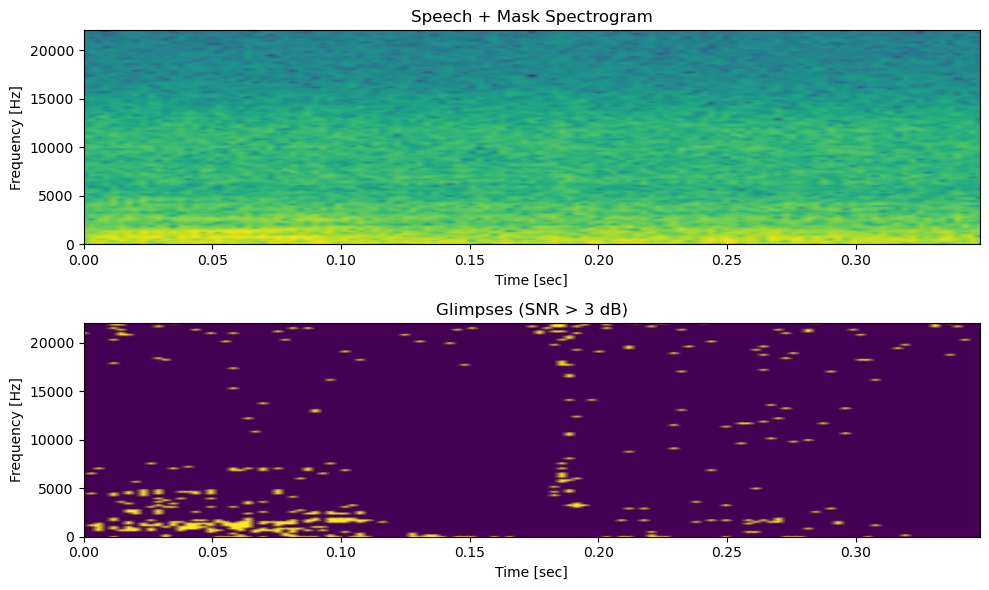

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft

mask_dir = r'C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrada 3 VCV\SSN all all\SSN_g1_66.wav'
speech_mask_dir = r'C:\Users\Mr Cab Driver\Documents\A FAKS FFZG\Diplomski\Fonetika\DIPLOMSKI RAD\Govorni materijal\Audio snimke govornika GM\Obrađeno 2 Audacity i Python\wav g1 VCV mask\S2ađa.wav'


# Load audio files
sr, mask = wavfile.read(mask_dir)
_, speech_mask = wavfile.read(speech_mask_dir)

# Determine the minimum length of the audio files
min_length = min(len(mask), len(speech_mask))

# Trim the audio files to the minimum length
mask = mask[:min_length]
speech_mask = speech_mask[:min_length]

# Compute STFT
f, t, mask_stft = stft(mask, sr)
_, _, speech_mask_stft = stft(speech_mask, sr)

# Convert to power spectrograms (magnitude squared)
mask_power = np.abs(mask_stft)**2
speech_mask_power = np.abs(speech_mask_stft)**2

# Calculate SNR
snr = 10 * np.log10(speech_mask_power / (mask_power + 1e-10))  # Adding a small value to avoid division by zero

# Identify glimpses where SNR > 3 dB
glimpses = snr > 3

# Visualize the glimpses on the spectrogram
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.pcolormesh(t, f, 10 * np.log10(speech_mask_power), shading='gouraud')
plt.title('Speech + Mask Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(2, 1, 2)
plt.pcolormesh(t, f, glimpses, shading='gouraud')
plt.title('Glimpses (SNR > 3 dB)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.tight_layout()
plt.show()